In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
from itertools import permutations
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
import src.ball_tree_numba as BTN 

In [2]:
data = pd.read_csv('./data/DR9_BGSBRIGHT_data.csv')

In [3]:
len(data)

14657737

Text(0, 0.5, 'DEC')

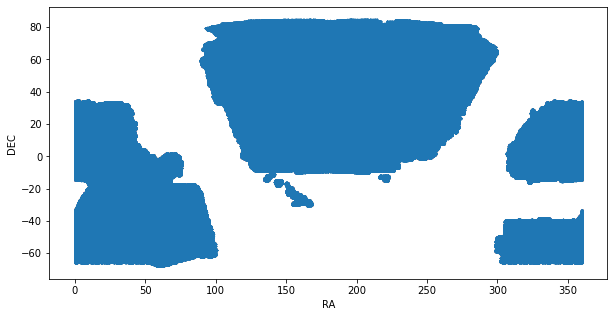

In [4]:
fig  = pl.figure(figsize=(10,5))
pl.scatter(data['RA'], data['DEC'], s=0.2)
pl.xlabel('RA')
pl.ylabel('DEC')

In [5]:
data['RA'][0], data['DEC'][0]

(50.01180684224499, 4.269975962093172)

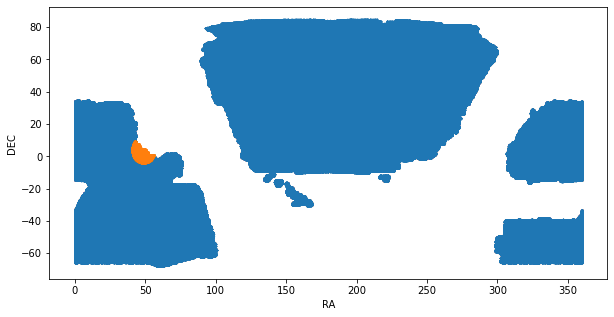

In [5]:
radii = [8]
for r in radii:
    fig  = pl.figure(figsize=(10,5))
    ii = (data['RA'] - data['RA'][100])**2 + (data['DEC'] - data['DEC'][100])**2 <= r**2
    pl.scatter(data['RA'][~ii], data['DEC'][~ii], s=0.2)
    pl.scatter(data['RA'][ii], data['DEC'][ii], s=0.5)

    pl.xlabel('RA')
    pl.ylabel('DEC')

In [7]:
D=3
K=5
LS=40
rseed = np.random.randint(10000)
np.random.seed(rseed)

# pre-run to jit compile the code
dist2, ind2 = BTN.BallTree(np.array(data[['RA','DEC']]), leaf_size=LS).query(data[['RA','DEC']], K)

-------------------------------------------------------
random seed = 8780
5


In [10]:
# a = [len(i) for i in ind2]
# pl.hist(a)

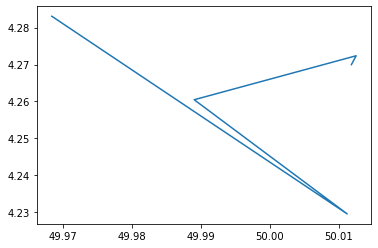

In [11]:
ind2[0]
pl.plot(data['RA'][ind2[0]],data['DEC'][ind2[0]])
pl.show()

In [12]:
# ball_tree = BallTree(data[['RA','DEC']], leaf_size=2)

In [14]:
# %%time
# # for i, r in enumerate(radii):
# r = 8
# indexes = ball_tree.query_radius(data[['RA','DEC']], r=r)
# print(indexes)
MEAN_E_R   =  [np.mean(data['E'][i]) for i in ind2]
MEAN_PHI_R =  [np.mean(data['PHI'][i]) for i in ind2]

In [15]:
new_data = pd.DataFrame( np.c_[data.values, MEAN_E_R, MEAN_PHI_R], columns=list(data.keys())+['MEAN_E_R','MEAN_PHI_R'])
new_data

,ID,RA,DEC,E1,E2,E,R,BA,PHI,MEAN_E_R,MEAN_PHI_R
0,0.0,50.011807,4.269976,-0.084959,0.027257,0.089225,8.166371,0.836168,1.415570,0.375745,-0.047097
1,1.0,50.012495,4.272378,0.119907,0.275814,0.300751,5.883485,0.537574,0.580353,0.375745,-0.047097
2,2.0,48.823746,3.321716,0.319423,-0.230888,0.394132,3.539613,0.434584,-0.312941,0.353066,-0.375055
3,3.0,48.828541,3.322617,0.146669,-0.053680,0.156183,1.425742,0.729830,-0.175425,0.353066,-0.375055
4,4.0,48.833968,3.362724,0.125419,-0.142682,0.189968,2.078933,0.680717,-0.424851,0.255459,-0.099516
...,...,...,...,...,...,...,...,...,...,...,...
14657732,14657732.0,117.867267,35.543613,-0.081000,0.073403,0.109311,1.151423,0.802921,1.202679,0.384485,0.425275
14657733,14657733.0,117.913651,35.584523,0.007894,0.223379,0.223519,1.128110,0.634629,0.767736,0.333702,-0.012863
14657734,14657734.0,117.918243,35.539066,-0.238178,-0.519580,0.571570,3.060961,0.272613,-1.000309,0.332602,0.488490
14657735,14657735.0,117.956709,35.543084,-0.007017,0.383459,0.383523,0.985896,0.445585,0.794547,0.321530,-0.023334


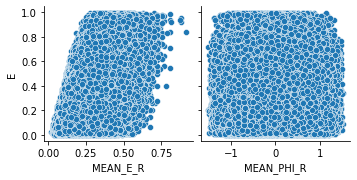

In [16]:
sns.pairplot(new_data, x_vars=['MEAN_E_R','MEAN_PHI_R'], y_vars=['E'])

In [17]:
E_vec = np.c_[ new_data['E']*np.cos(new_data['PHI']*np.pi/180), new_data['E']*np.sin(new_data['PHI']*np.pi/180) ]
E_mean_vec_R = np.c_[new_data['MEAN_E_R']*np.cos(new_data['MEAN_PHI_R']*np.pi/180),  new_data['MEAN_E_R']*np.sin(new_data['MEAN_PHI_R']*np.pi/180) ]

In [18]:
np.shape(E_vec), np.shape(E_mean_vec_R)

((14657737, 2), (14657737, 2))

/tmp/ipykernel_244972/3441521293.py:1: RuntimeWarning: invalid value encountered in arccos
  align_R = np.arccos( sum(E_vec.T*E_mean_vec_R.T)/(np.sqrt(sum(E_vec.T*E_vec.T))*np.sqrt(sum(E_mean_vec_R.T*E_mean_vec_R.T))) )*180/np.pi


1.4711353200675321


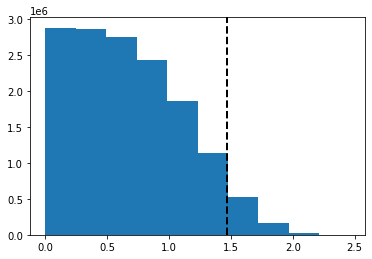

In [23]:
align_R = np.arccos( sum(E_vec.T*E_mean_vec_R.T)/(np.sqrt(sum(E_vec.T*E_vec.T))*np.sqrt(sum(E_mean_vec_R.T*E_mean_vec_R.T))) )*180/np.pi
align_R = align_R[~np.isnan(align_R)]
_ = pl.hist( align_R )
print(np.percentile(align_R, 95))
pl.axvline(np.percentile(align_R, 95), label='95%', color='k', linestyle='dashed', linewidth=2)
# pl.yscale('log')
pl.show()

In [24]:
new_data.to_csv('./data/ALIGN_BGS_k5.csv', columns=list(data.keys())+['MEAN_E_R','MEAN_PHI_R'])